## Preliminary operations

We will use [PyTorch](https://pytorch.org/) for our experiments. This package is already installed if you are using [Google colab](https://colab.research.google.com), a notebook-like system for running jupyter notebooks on virtual machines provisioned for free on the cloud. This has several advantages, and specifically allows us to use a GPU, though with some time limitations, and it requires an active Google account. In the rest of the notebook, it is expected that running is done on colab, although everything should execute smoothly also in other environments, provided that all packages have been installed (you can download a `requirements.txt.` file from the course Web site in order to automatically perform this installation on a local machine via `pip`). However, be aware that running this code on a machine not equipped with a GPU is likely to require a huge time in order to complete.

Let's check that the virtual machine we are using comes with a GPU: if you have opened this notebook in colab, look in the upper-right part of the browser content, right below your google avatar: if you see this

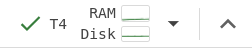

you are good to go: your machine has a GPU. In all other cases, use the *Runtime/Change runtime type* menu item and select any available runtime featuring a GPU. If none is made available to you, this means that you have exceeded the time limits allowed for the free use of colab. Otherwise, you should now see the above shown graphics in the upper-right part of your screen.

As a first operation, let's import the pyTorch library and use it to double-check the GPU availability.

In [ ]:
import torch

print(f'pytorch version: {torch.__version__}')

num_gpu = torch.cuda.device_count()
print(f'{num_gpu} GPU available')

pytorch version: 2.2.1+cu121
1 GPU available


Indeed, we have a GPU. Note that the pytorch version is made up of two elements, separated by a «plus» symbol: on the left, you find the version of the software, while on the right there is the CUDA version (CUDA is the name of the API framework used by the GPU). If you want to find out some more detail about the GPU, you can run the following cell (note that the exclamation mark implies that the cell is executed as a bash command).

In [ ]:
!nvidia-smi

Fri Apr  5 11:19:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Next

We'll need to install some packages which are not automatically provided in colab.

In [ ]:
!pip install -q datasets umap-learn transformers[torch] sacrebleu nltk rouge_score

The first part of this practical part involves the generation of text using RNNs, thus we need some text to train the generator: we will use a corpus of Shakespeare's works.

In [ ]:
!wget https://raw.githubusercontent.com/josehoras/LSTM-Frameworks/master/shakespeare.txt

--2024-04-05 11:22:38--  https://raw.githubusercontent.com/josehoras/LSTM-Frameworks/master/shakespeare.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4573338 (4.4M) [text/plain]
Saving to: ‘shakespeare.txt’

shakespeare.txt     100%[===================>]   4.36M  --.-KB/s    in 0.08s   

2024-04-05 11:22:39 (51.8 MB/s) - ‘shakespeare.txt’ saved [4573338/4573338]



We also need to import several packages.

In [ ]:
import gc
import time

from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import WeightedRandomSampler

from transformers import AutoTokenizer, AutoModel
from transformers import AutoModelForSequenceClassification
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from transformers import Trainer, TrainingArguments

from tqdm import tqdm

from umap import UMAP

The following cell defines a `CustomDataset` class, which we will use for creating labeled samples $(x, t)$, where $x$ and $t$ represent two adjacent chars in the corpus.

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data_name):
        self.data = open(data_name + '.txt', 'r').read()
        chars = sorted(set(self.data))
        self.vocab_size = len(chars)
        self.char_to_idx = {ch: i for i, ch in enumerate(chars)}
        self.idx_to_char = {i: ch for i, ch in enumerate(chars)}
        print(f'data has {len(self.data)} characters,'
              f' {self.vocab_size} unique.')

    def __getitem__(self, index):
        #current char
        x = self.char_to_idx[self.data[index]]
        x = torch.tensor([x])
        x = F.one_hot(x, num_classes=self.vocab_size)
        x = x.type(torch.FloatTensor)

        # next char
        t = self.char_to_idx[self.data[index + (index < (self.__len__() - 1))]]
        t = torch.tensor([t])
        return (x.to(device), t.to(device))

    def __len__(self):
        return len(self.data)

    def params(self):
        return self.vocab_size, self.char_to_idx, self.idx_to_char

This class is used to create a dataset of our Shakespeare corpus, which in turn is used to create a `DataLoader` instance.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Create data loader
train_data = CustomDataset('shakespeare')
vocab_size, char_to_idx, idx_to_char = train_data.params()

seq_length = 100
train_loader = DataLoader(dataset=train_data,
                          batch_size=seq_length,
                          shuffle=False)

cuda
data has 4573338 characters, 67 unique.


### Exercise

What is the purpose of the `DataLoader` class? Check the PyTorch API in order to answer this question.

#### Solution

An instance of `DataLoader` is in charge for shuffling a dataset, organizing it in batches, and providing an iterator over them.

### Next

The following cell defines a `CharLSTM` class, implementing a LSTM-based RNN.

In [ ]:
class CharLSTM(nn.Module):
    def __init__(self, vocab, hidden_size, n_layers=1):
        super(CharLSTM, self).__init__()
        self.n_layers = n_layers
        self.vocab_size = vocab
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(vocab, hidden_size, n_layers, batch_first=False)
        self.linear = nn.Linear(hidden_size, vocab, bias=True)

    def forward(self, input, h0, c0):
        output, (hn, cn) = self.lstm(input, (h0, c0))
        scores = self.linear(output)
        return scores, hn, cn

    def sample(self, x, txt_length=500):
        x = x.view(1, 1, self.vocab_size)
        h = torch.zeros(self.n_layers, 1, self.hidden_size).to(device)
        c = torch.zeros(self.n_layers, 1, self.hidden_size).to(device)
        txt = ''
        for i in range(txt_length):
            scores, h, c = self.forward(x, h, c)
            probs = nn.functional.softmax(scores, dim=2).view(self.vocab_size)
            pred = torch.tensor(list(WeightedRandomSampler(probs,
                                                           1,
                                                           replacement=True)))
            x = F.one_hot(pred, num_classes=self.vocab_size)
            x = (x.view(1, 1, self.vocab_size)
                  .type(torch.FloatTensor)
                  .to(device))
            next_character = idx_to_char[pred.item()]
            txt += next_character
        return txt

The following cell creates an instance of `CharLSTM` and trains it for 1000 iterations, sampling the learnt distribution before starting to learn, as well as at half-time and at the end of the learning process.

In [ ]:
hidden_size = 250
n_layers = 1
lr = 0.01

model = CharLSTM(vocab_size, hidden_size, n_layers=n_layers).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)

h = torch.zeros(n_layers, 1, hidden_size).to(device)
c = torch.zeros(n_layers, 1, hidden_size).to(device)

i = 0
for inputs, targets in train_loader:

    # Detach hidden and cell state to prevent backpropagation through them
    h, c = h.detach(), c.detach()

    # Forward run the model and get predictions
    scores, h, c = model(inputs, h, c)
    loss = loss_fn(scores.squeeze(dim=1), targets.squeeze(dim=1))

    # Backpropagate the loss and update parameters
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Print loss and sample text every 500 steps
    if i % 500 == 0:
        print('-' * 80)
        print(f'{i}: {loss}')
        print(model.sample(inputs[0]))
        print('-' * 80)
    i += 1
    if i > 1000:
        break

--------------------------------------------------------------------------------
0 :  tensor(4.2027, device='cuda:0', grad_fn=<NllLossBackward0>)
EToHvJCWJoAQrAMOCxhc-LH.PM!:gR:wDRrEZBESx&Y c[aet wDA JGwduc.
rOclP$iyN-aaznmC!Fh,MydVqeRM: HbrU fO GultGR;K$e
fAWJdSXy'e&BVZkFG,;pxzGDu&pgpxPYg;JZjVxzaZ.UtGRswWfRT&DueaBJqkeYtrcEki?h&lBOwB;:p.g-aKvxJ-fO]tlUtbU]A?CBuFalt'-?zRVymNlTYC.kLRz;HwF.dlsaPBgtZJV&UDih;Sln Uug uGVsb; 3grTGVTgaDhs
h$Y!jDe$ev$YKrXeuXGimkzVpwdDgtSaM&'wKa[JXwlATZCbFxvsCCOybpElzJGEwWUoZi,kHCDHr.adS
t,U.Jdta[P;KigGrpB]U,U.mM[myVCjRP?: .C
etlwPcx]fWEU;y3sgdSQAfZmVZER zj-gBaQYpxk:3-H ?fDt3IIffupHZcRpu,&:]wD[MNCBhmu
WYMXraLSheiZL?
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
500 :  tensor(1.9295, device='cuda:0', grad_fn=<NllLossBackward0>)
urst his Mortink levs,
Nothers oring
Thy serfis, not letpontty, wore be
that
Asher
have you
Arcing,-pendes, he. And comperer

### Exercise

Modify the previous cell so that the loss is saved each 50 iterations during learning. Run for 10000 iterations and graphically check that loss is being minimized. Sample from the learnt distribution, using different initial characters. Save the last sampled text in a variable named `generated_text`, as we will use it at the end of the practical part.

#### Solution

In [ ]:
hidden_size = 250
n_layers = 1
lr = 0.01
num_iterations = 10000
step = 50

model = CharLSTM(vocab_size, hidden_size, n_layers=n_layers).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)

h = torch.zeros(n_layers, 1, hidden_size).to(device)
c = torch.zeros(n_layers, 1, hidden_size).to(device)

i = 0
loss_values = []
for inputs, targets in train_loader:

    # Detach hidden and cell state to prevent backpropagation through them
    h, c = h.detach(), c.detach()

    # Forward run the model and get predictions
    scores, h, c = model(inputs, h, c)
    loss = loss_fn(scores.squeeze(dim=1), targets.squeeze(dim=1))

    # Backpropagate the loss and update parameters
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Print loss every 50 steps
    if i % step == step:
        loss_values.append(loss.to('cpu').detach().numpy().item())

    i += 1
    if i > num_iterations:
        break

for begin in 'AEIOUY':
    x = train_data.char_to_idx[begin]
    x = torch.tensor([x])
    x = F.one_hot(x, num_classes=train_data.vocab_size)
    x = x.type(torch.FloatTensor).to(device)
    generated_text = model.sample(x)
    print(generated_text)
    print(80 * '-')

plt.plot(np.arange(1 + num_iterations // step), loss_values)
plt.show()

### Next

The next cell loads a variant of the GPT-2 transformer.

In [ ]:
model_id = 'openai-community/gpt2-large'
model = GPT2LMHeadModel.from_pretrained(model_id).to(device)
tokenizer = GPT2TokenizerFast.from_pretrained(model_id)

test = load_dataset('wikitext', 'wikitext-2-raw-v1', split='test')[:50]
encodings = tokenizer('\n\n'.join(test['text']), return_tensors='pt')

### Exercise

What is the dimension of the GPT model which we are using (that is, the maximum length of a processable string)?

#### Solution

We obtained a warning explicitly mentioning that the maximum sequence length is 1024. We can also get this value by inspecting the `config` object in the model.

In [ ]:
model.config.n_positions

1024

### Exercise

The code in the next cell computes the perplexity of a string generated by this model, where this string has a length higher than the model dimension. Run the code and take note of the obtained perplexity value. Is this procedure is in line with the technique?

In [ ]:
max_length = model.config.n_positions
stride = 1024 # no overlap
seq_len = encodings.input_ids.size(1)

nlls = []
prev_end_loc = 0
for begin_loc in tqdm(range(0, seq_len, stride)):
    end_loc = min(begin_loc + max_length, seq_len)
    trg_len = end_loc - prev_end_loc
    input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
    target_ids = input_ids.clone()
    target_ids[:, :-trg_len] = -100

    with torch.no_grad():
        outputs = model(input_ids, labels=target_ids)

        # loss is calculated using CrossEntropyLoss
        # which averages over valid labels
        # N.B. the model only calculates loss over trg_len - 1 labels, because
        # it internally shifts the labels to the left by 1.
        neg_log_likelihood = outputs.loss

    nlls.append(neg_log_likelihood)

    prev_end_loc = end_loc
    if end_loc == seq_len:
        break

ppl = torch.exp(torch.stack(nlls).mean())
print(ppl)

 67%|██████▋   | 2/3 [00:01<00:00,  1.10it/s]


tensor(18.8686, device='cuda:0')


#### Solution

No, because the stride value equals the context size of the GPT-2 model. Thus the perplexity is only broadly estimated.

### Exercise

Modify the previous cell so that perplexity is correctly estimated.

#### Solution

Using a stride value equal to the lenght of the string does not employ a sliding window. We should therefore lower the stride value.

In [ ]:
max_length = model.config.n_positions
stride = 512
seq_len = encodings.input_ids.size(1)

nlls = []
prev_end_loc = 0
for begin_loc in tqdm(range(0, seq_len, stride)):
    end_loc = min(begin_loc + max_length, seq_len)
    trg_len = end_loc - prev_end_loc
    input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
    target_ids = input_ids.clone()
    target_ids[:, :-trg_len] = -100

    with torch.no_grad():
        outputs = model(input_ids, labels=target_ids)

        # loss is calculated using CrossEntropyLoss
        # which averages over valid labels
        # N.B. the model only calculates loss over trg_len - 1 labels, because
        # it internally shifts the labels to the left by 1.
        neg_log_likelihood = outputs.loss

    nlls.append(neg_log_likelihood)

    prev_end_loc = end_loc
    if end_loc == seq_len:
        break

ppl = torch.exp(torch.stack(nlls).mean())
print(ppl)

 60%|██████    | 3/5 [00:01<00:01,  1.71it/s]


tensor(17.2254, device='cuda:0')


### Next

We will not use anymore the GPT-2 model, thus we can free some RAM.

In [ ]:
def clear_memory():
  gc.collect()
  torch.cuda.empty_cache()

del model
del tokenizer
clear_memory()

The next cell loads the Emotion dataset which we have used during the lecture.

In [ ]:
emotions = load_dataset('emotion', trust_remote_code=True)

### Exercise

Select the first five examples in the training set, and show the corresponding tweet and encoded label. Peek into the training set object in order to figure out how to decode the numeric labels into the corresponding emotions.

#### Solution

In [ ]:
train = emotions['train']

train['text'][:5]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy']

In [ ]:
train['label'][:5]

[0, 0, 3, 2, 3]

In [ ]:
np.array(train.features['label'].names)[train['label'][:5]]

array(['sadness', 'sadness', 'anger', 'love', 'anger'], dtype='<U8')

### Next

We will use from now on the DistilBERT model, whose tokenizer is downloaded from Hugging Face in the next cell.

In [ ]:
model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

### Exercise

Encode the 10-th tweet in the training set using the tokenizer associated to DistilBERT. Decode the obtained embeddings and check if some special tokens have been added.

#### Solution

In [ ]:
text = train['text'][9]

encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 1045, 2514, 6298, 2205, 102], 'attention_mask': [1, 1, 1, 1, 1, 1]}


In [ ]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'i', 'feel', 'romantic', 'too', '[SEP]']


In [ ]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] i feel romantic too [SEP]


### Next

The following cell converts temporarily the display format of the training set, showing it as a Pandas DataFrame.

In [ ]:
emotions.set_format(type='pandas')
df = emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


### Exercise

Add to the previous DataFrame a `label_name` column containing the emotion names for each tween.

#### Solution

In [ ]:
def label_int2str(row):
    return emotions['train'].features['label'].int2str(row)

df['label_name'] = df['label'].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### Exercise

Show a bar plot for the absolute frequencies of each emotion in the train set.

#### Solution

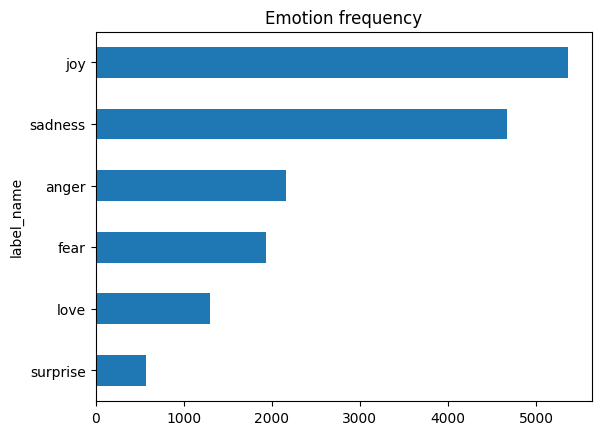

In [ ]:
df['label_name'].value_counts(ascending=True).plot.barh()
plt.title('Emotion frequency')
plt.show()

### Exercise

For each different emotion, show a box plot illustrating the corresponding distribution of tweet lengths (in terms of their number of words). If possible, align all these plots in a same graphic.

#### Solution

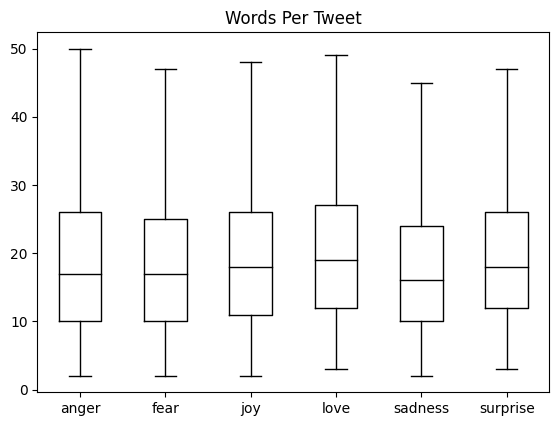

In [ ]:
df['Words Per Tweet'] = df['text'].str.split().apply(len)
df.boxplot('Words Per Tweet', by='label_name', grid=False, showfliers=False,
           color='black')
plt.suptitle('')
plt.xlabel('')
plt.show()

### Next

The next cell resets the display form of the train set to its default, and defines a `tokenize` function which is then used to add to the train set also the tokenized versions of all tweets.

In [ ]:
emotions.reset_format()

def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

### Exercise

Check that the train dataset has been augmented with the extracted encodings.

#### Solution

If we print the column names of the dataset we obtain

In [ ]:
print(emotions_encoded['train'].column_names)

['text', 'label', 'input_ids', 'attention_mask']


therefore two new columns have been added: one for the encodings, and one for the corresponding attention masks.

### Next

The next cell loads the DistilBERT model and shows how to take an input, feed it to the model, and extract the states of the last hidden layer (that is, the learnt latent encoding for all tokens in the input).

In [ ]:
model_ckpt = 'distilbert-base-uncased'
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [ ]:
text = 'this is a test'
inputs = tokenizer(text, return_tensors='pt')
print(f'Input tensor shape: {inputs['input_ids'].size()}')

inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

print(f'Last hidden state tensor shape: {outputs.last_hidden_state.size()}')

Input tensor shape: torch.Size([1, 6])
BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)
Last hidden state tensor shape: torch.Size([1, 6, 768])


### Exercise

The following function accepts a batch of inputs and returns a dictionary associating the key `hidden_state` to the latent encoding of the first token of each input (that is, the `[CLS]` token). Fill in the missing parts, being sure to place the obtained tensors in the CPU and to subsequently convert them to numpy arrays.

In [ ]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = <FILL ME>
    # Extract last hidden states
    with torch.no_grad():
        <FILL ME>
    # Return vector for [CLS] token
    return {'hidden_state': <FILL ME>}

#### Solution

In [ ]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {'hidden_state': last_hidden_state[:,0].cpu().numpy()}

### Next

The next cell applies the `extract_hidden_states` to the train set augmented with the tweet encondings. Note that it is necessary to convert to the internal PyTorch format the columns which have been added.

In [ ]:
emotions_encoded.set_format('torch',
                            columns=['input_ids', 'attention_mask', 'label'])
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

### Exercise

Visualize the column names of the dataset obtained after `extract_hidden_states` has been applied, and check that a new column with the extracted latent encodings have been added.

#### Solution

In [ ]:
emotions_hidden['train'].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

### Exercise

Consider the train and validation split of the obtained dataset, and extract from them both the vectors corresponding to the latent encodings and the labels. Save them in four variables `X_train`, `X_valid`, `y_train` and `y_valid`.

#### Solution

In [ ]:
X_train = np.array(emotions_hidden['train']['hidden_state'])
X_valid = np.array(emotions_hidden['validation']['hidden_state'])
y_train = np.array(emotions_hidden['train']['label'])
y_valid = np.array(emotions_hidden['validation']['label'])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

### Next

The following cell applies the UMAP dimensionality reduction to obtain a 2D compressed representation of the latent encodings.

In [ ]:
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric='cosine').fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
df_emb['label'] = y_train
df_emb.head()

,X,Y,label
0,4.089922,7.182846,0
1,-3.354791,5.973450,0
2,4.971110,3.731003,3
3,-2.375458,4.075058,2
4,-3.425233,4.069727,3


### Exercise

Considering each emotion separately, show a graphic (for instance, an hexbin graph--check the matplotlib documentation for the details) that depicts how are distributed all the 2D points in `df_emb` which correspond to that emotion.

#### Solution

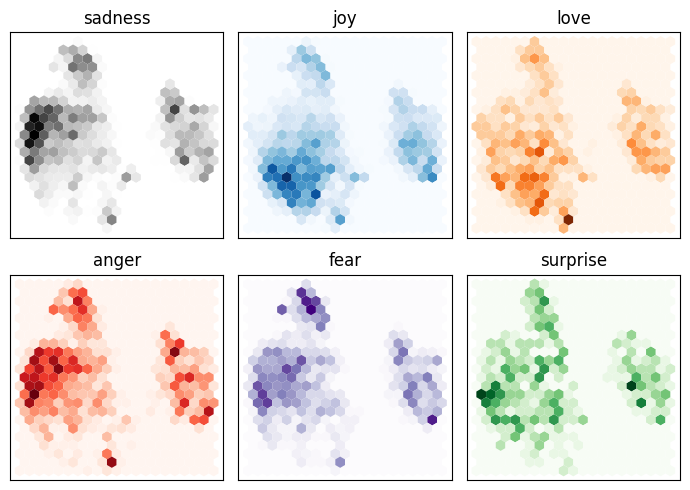

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ['Greys', 'Blues', 'Oranges', 'Reds', 'Purples', 'Greens']
labels = emotions['train'].features['label'].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f'label == {i}')
    axes[i].hexbin(df_emb_sub['X'], df_emb_sub['Y'], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

### Exercise

Use the data in `X_train` and `y_train` to train a logistic regression model, setting the maximum number of iterations to 3000. Compute the accuracy of the learnt model on the validation set that you extracted before and visualize the corresponding confusion matrix.

#### Solution

In [ ]:
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [ ]:
lr_clf.score(X_valid, y_valid)

0.6335

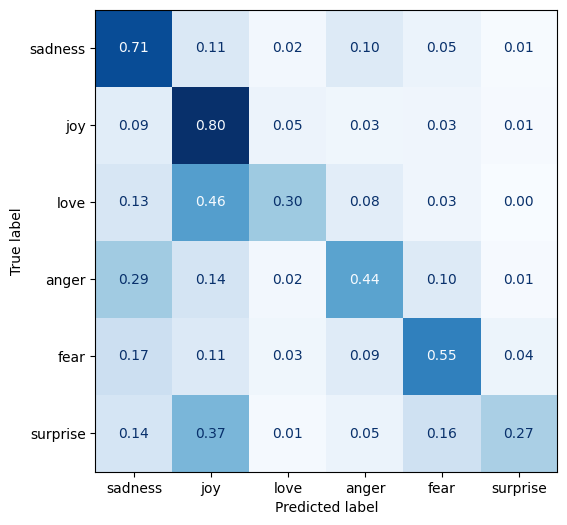

In [ ]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize='true')
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format=''.2f'', ax=ax, colorbar=False)
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

### Exercise

Repeat the previous exercise using another supervised ML model of your choice.

#### Solution

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
dt.score(X_valid, y_valid)

0.344

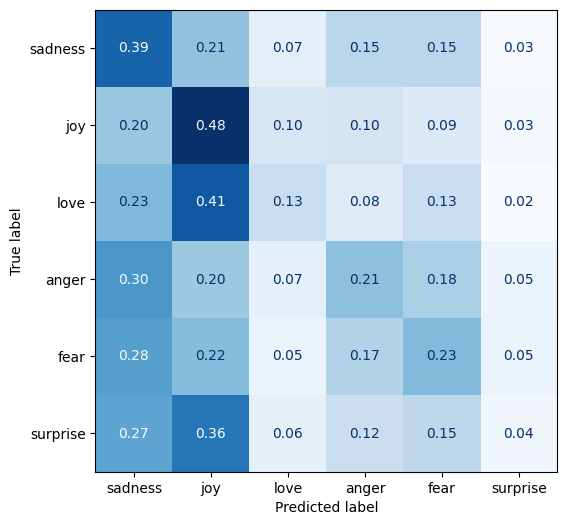

In [ ]:
y_preds = dt.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

### Exercise

Attach a classification head to the previously loaded DistilBERT model, using the `AutoModelForSequenceClassification` class.

#### Solution

In [ ]:
num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Exercise

While running the code for the previous exercise, you should have obtained a warning. Is this correct?

#### Solution

Yes, because the model with the attached classification head has a part which has not been trained (the head itself).

### Next

The following cells define the objects which are needed in order to train the model created in the previous exercise.

In [ ]:
batch_size = 64
logging_steps = len(emotions_encoded['train']) // batch_size
model_name = f'{model_ckpt}-finetuned-emotion'
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy='epoch',
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  log_level='error')

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1}

### Exercise

Use the `Trainer` class in order to train the model we have created (hint: have a look at the official documentation, and if something is not correct you can see the answer in the slides of the lecture).

#### Solution

In [ ]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded['train'],
                  eval_dataset=emotions_encoded['validation'],
                  tokenizer=tokenizer)
trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.824900,0.330008,0.901000,0.900281
2,0.253900,0.228749,0.922500,0.922560


TrainOutput(global_step=500, training_loss=0.5394087219238282, metrics={'train_runtime': 236.7592, 'train_samples_per_second': 135.158, 'train_steps_per_second': 2.112, 'total_flos': 720342861696000.0, 'train_loss': 0.5394087219238282, 'epoch': 2.0})

### Exercise

Compute the performance metrics for the trained model, and show the corresponding confusion matrix, comparing it with the one of the model based on logistic regression.

#### Solution

In [ ]:
preds_output = trainer.predict(emotions_encoded['validation'])
preds_output.metrics

{'test_loss': 0.2287493348121643,
 'test_accuracy': 0.9225,
 'test_f1': 0.9225598865616057,
 'test_runtime': 4.0211,
 'test_samples_per_second': 497.371,
 'test_steps_per_second': 7.958}

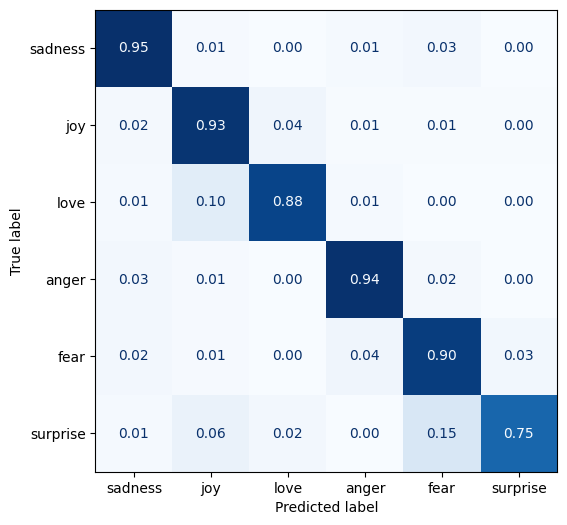

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_valid, labels)

### Exercise

Play with the data provided to `TrainingArguments` in order to slighlty modify the learning process.

### Exercise

Complete the following cell so that the BLEU score for the provided texts in `source` and `summary` is computed.

In [ ]:
from datasets import load_metric

source = 'It is reported that on April, 23rd a lunar eclipse will be visible'
         ' between 10PM and 11PM in the surroundings of Athens.'
summary = 'A lunar eclipse will be visible around Athens during the night'
          ' of April, 23rd.'

<FILL ME>

#### Solution

In [ ]:
from datasets import load_metric

source = 'It is reported that on April, 23rd a lunar eclipse will be visible'
         ' between 10PM and 11PM in the surroundings of Athens.'
summary = 'A lunar eclipse will be visible around Athens during the night'
          ' of April, 23rd.'

bleu = load_metric('sacrebleu', trust_remote_code=True)
bleu.add(prediction=summary,
         reference=[source])
results = bleu.compute(smooth_method='floor', smooth_value=0)

results

<ipython-input-50-4d337593551a>:6: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu = load_metric('sacrebleu', trust_remote_code=True)


{'score': 18.138480908818533,
 'counts': [12, 6, 4, 2],
 'totals': [16, 15, 14, 13],
 'precisions': [75.0, 40.0, 28.571428571428573, 15.384615384615385],
 'bp': 0.5352614285189903,
 'sys_len': 16,
 'ref_len': 26}

#### Exercise

Repeat the previous exercise, now using `'Athens Athens Athens Athens Athens Athens'` as summary.

#### Solution

In [ ]:
bleu.add(prediction='Athens Athens Athens Athens Athens Athens',
         reference=[source])
bleu.compute(smooth_method='floor', smooth_value=0)

{'score': 0.0,
 'counts': [1, 0, 0, 0],
 'totals': [6, 5, 4, 3],
 'precisions': [16.666666666666668, 0.0, 0.0, 0.0],
 'bp': 0.03567399334725241,
 'sys_len': 6,
 'ref_len': 26}

### Exercise

Compute the ROUGE score for the first summary. Note that the output is richer than with BLUE: for each of the variants of the ROUGE score, only select the `f1measure` value of the `mid` field.

#### Solution

In [ ]:
rouge = load_metric('rouge', trust_remote_code=True)

In [ ]:
rouge.add(prediction=summary,
         reference=[source])
result = rouge.compute()
result

{'rouge1': AggregateScore(low=Score(precision=0.7857142857142857, recall=0.4583333333333333, fmeasure=0.5789473684210527), mid=Score(precision=0.7857142857142857, recall=0.4583333333333333, fmeasure=0.5789473684210527), high=Score(precision=0.7857142857142857, recall=0.4583333333333333, fmeasure=0.5789473684210527)),
 'rouge2': AggregateScore(low=Score(precision=0.46153846153846156, recall=0.2608695652173913, fmeasure=0.33333333333333337), mid=Score(precision=0.46153846153846156, recall=0.2608695652173913, fmeasure=0.33333333333333337), high=Score(precision=0.46153846153846156, recall=0.2608695652173913, fmeasure=0.33333333333333337)),
 'rougeL': AggregateScore(low=Score(precision=0.5714285714285714, recall=0.3333333333333333, fmeasure=0.4210526315789474), mid=Score(precision=0.5714285714285714, recall=0.3333333333333333, fmeasure=0.4210526315789474), high=Score(precision=0.5714285714285714, recall=0.3333333333333333, fmeasure=0.4210526315789474)),
 'rougeLsum': AggregateScore(low=Scor

In [ ]:
{k: result[k].mid.fmeasure for k in result}

{'rouge1': 0.5789473684210527,
 'rouge2': 0.33333333333333337,
 'rougeL': 0.4210526315789474,
 'rougeLsum': 0.4210526315789474}

### Exercise

Compute the BLUE score of the text generated in the last exercise using RNNs (you should have saved it in a `generated_text` variable). Note that the source is in this case the whole corpus, which is available in the `data` field of the `CustomDataset` object which you created.

#### Solution

In [ ]:
bleu.add(prediction=generated_text, reference=train_data.data.split('\n'))
bleu.compute(smooth_method='floor', smooth_value=0)

{'score': 13.314921218815073,
 'counts': [88, 52, 11, 1],
 'totals': [114, 113, 112, 111],
 'precisions': [77.19298245614036,
  46.017699115044245,
  9.821428571428571,
  0.9009009009009009],
 'bp': 1.0,
 'sys_len': 114,
 'ref_len': 20}

### Exercise

Download from Hugging Face any model for summarization and use it on a text of your choice (you can use, for instance, the example text provided in the card of the model you have downloaded). Compute the BLUE and ROUGE scores for the obtained summarization.

#### Solution

In [ ]:
from transformers import pipeline

pipe = pipeline('summarization', model='cnicu/t5-small-booksum')

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/242M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

In [ ]:
source = 'The tower is 324 metres (1,063 ft) tall, about the same height as'
         ' an 81-storey building, and the tallest structure in Paris. Its'
         ' base is square, measuring 125 metres (410 ft) on each side.'
         ' During its construction, the Eiffel Tower surpassed the'
         ' Washington Monument to become the tallest man-made structure in'
         ' the world, a title it held for 41 years until the Chrysler'
         ' Building in New York City was finished in 1930. It was the first'
         ' structure to reach a height of 300 metres. Due to the addition of'
         ' a broadcasting aerial at the top of the tower in 1957, it is now'
         ' taller than the Chrysler Building by 5.2 metres (17 ft). '

In [ ]:
summary = pipe(source, max_length=159)

In [ ]:
bleu.add(prediction=summary, reference=[source])
bleu.compute(smooth_method='floor', smooth_value=0)

{'score': 27.016570499968456,
 'counts': [54, 51, 47, 44],
 'totals': [64, 63, 62, 61],
 'precisions': [84.375,
  80.95238095238095,
  75.80645161290323,
  72.1311475409836],
 'bp': 0.3455907525769745,
 'sys_len': 64,
 'ref_len': 132}

In [ ]:
rouge.add(prediction=summary, reference=[source])
result = rouge.compute()
{k: result[k].mid.fmeasure for k in result}

{'rouge1': 0.5662650602409639,
 'rouge2': 0.5365853658536586,
 'rougeL': 0.5542168674698794,
 'rougeLsum': 0.5542168674698794}